## Modeling

In [1]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
client = bigquery.Client()
from Predicting_Purchase_Intention.utils.get_data import get_raw_data
from Predicting_Purchase_Intention.utils.clean_data import drop_cols, clean_data
from sklearn.pipeline import Pipeline, make_pipeline 
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [3]:
import seaborn as sns

In [31]:
test_df = pd.read_csv('../raw_data/test_3days_dataset.csv')

In [22]:
list_y = list(set(test_df['target_variable'].values)) #unique values in the target variable
list_y.remove(0)
#dependent on what we eventually agree as the main class for the precision target
test_df['target_variable'] = test_df['target_variable'].replace(to_replace=list_y, value = -1)\
.replace(to_replace=0, value = 1).replace(to_replace=-1, value = 0)

In [91]:
def pipeline_normalizer(X:pd.DataFrame) -> pd.DataFrame:
    def find_outliers_IQR(X:pd.DataFrame) -> pd.DataFrame:
        q1=X.quantile(0.25)
        q3=X.quantile(0.75)
        IQR=q3-q1
        outliers = X[((X<(q1-1.5*IQR)) | (X>(q3+1.5*IQR)))]
        #Outliers are identified by the imbalance in their quantile differences
        return len(outliers)

    binary_col=[]
    min_max_scaling_cat = []
    standard_scaling_cat = []
    for num in X.columns:
        if X[num].max() == 1 and X[num].min() == 0:
            #test to see which are categorical data of 1's and 0's
            binary_col.append(num)

        if find_outliers_IQR(X[num])>100:
            #arbitrarily set at 100 so we dont lose information in the noise--> MinMax Scaler for these
            min_max_scaling_cat.append(num)
        else:
            standard_scaling_cat.append(num)
            #StandardScaler for these. Normally distributed with fewer than a hundred outliers

    if len(min_max_scaling_cat)+len(standard_scaling_cat)+len(binary_col) == len(X.columns):
        #test to see if the 
        print('Ok to continue')
    else:
        print('Something is wrong, Hold!')
    
    #make pipeline to standardize datasets with MinMaxScaler and Standardized Scaler where necessary
    preproc_minmaxscaler = make_pipeline(
        SimpleImputer(strategy = 'most_frequent'),
        #A lot of the nan's in the dataset correspon to zero which is the most frequent value
        MinMaxScaler())

    preproc_standardscaler = make_pipeline(
        SimpleImputer(strategy = 'most_frequent'),
        StandardScaler())

    categorical_scaler = make_pipeline(
        SimpleImputer(strategy="most_frequent"))
    #OneHotEncoder(handle_unknown="ignore")
    # Assuming I'm getting this data already encoded
    #if not unhash the line above and press tab
    preproc = make_column_transformer(
        (preproc_minmaxscaler, min_max_scaling_cat),
        (preproc_standardscaler, standard_scaling_cat),
        (categorical_scaler, binary_col),    
        remainder="drop")
    
    return preproc


In [40]:
# #make pipeline to standardize datasets with MinMaxScaler and Standardized Scaler where necessary
# preproc_minmaxscaler = make_pipeline(
#     SimpleImputer(strategy = 'most_frequent'),
#     #A lot of the nan's in the dataset correspon to zero which is the most frequent value
#     MinMaxScaler())

# preproc_standardscaler = make_pipeline(
#     SimpleImputer(strategy = 'most_frequent'),
#     StandardScaler())

# categorical_scaler = make_pipeline(
#     SimpleImputer(strategy="most_frequent"))
# #OneHotEncoder(handle_unknown="ignore")
# # Assuming I'm getting this data already encoded
# #if not unhash the line above and press tab
# preproc = make_column_transformer(
#     (preproc_minmaxscaler, min_max_scaling_cat),
#     (preproc_standardscaler, standard_scaling_cat),
#     (categorical_scaler, binary_col),    
#     remainder="drop")

In [96]:
def initialize_model(X, y, pipe, drop=False):
    print('Initializing Model')
    '''
    Initialize XGBoost Classifier
    '''
    y = y.replace(to_replace=1, value = -1)\
    .replace(to_replace=0, value = 1).replace(to_replace=-1, value = 0)
    #based on predicting the non purchasers
    threshold_question = input('Do you want to drop highly correlated features: ').lower()
    if threshold_question == 'yes' or 'y':
        drop == True
    if drop:
        threshold = int(input('Please Select Correlation Threshold for Columns to drop: '))
        num_corr_threshold = threshold/100
        corr_num = X[min_max_scaling_cat].corr()
        corr_num_upper_triangle = corr_num.where(np.triu(np.ones(corr_num.shape),k=1).astype(np.bool)).abs()
        num_col_to_drop = [column for column in corr_num_upper_triangle.columns if any(corr_num_upper_triangle[column] > num_corr_threshold)]
        corr_num_s = X[standard_scaling_cat].corr()
        corr_num_upper_triangle_s = corr_num_s.where(np.triu(np.ones(corr_num_s.shape),k=1).astype(np.bool)).abs()
        num_col_to_drop_s = [column for column in corr_num_upper_triangle_s.columns if any(corr_num_upper_triangle_s[column] > num_corr_threshold)]
        
        print(f'You dropped {len(num_col_to_drop)+len(num_col_to_drop_s)} features')
        X = X.drop(columns = num_col_to_drop).drop(columns = num_col_to_drop_s)
        
        #initialize model
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        #Split Training and Test Set
        model = XGBClassifier(learning_rate = 0.1, max_depth = 10, n_estimators = 500)
        pipe_baseline = make_pipeline(pipe, model)
        pipe_baseline.fit(X_train,y_train)
        scores = cross_validate(pipe_baseline, X_test, y_test, cv=5, scoring=['precision','f1'])
        return (scores['test_f1'].mean(), scores['test_precision'].mean())
    
    if drop == False:
        #initialize model
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        #Split Training and Test Set
        model = XGBClassifier(learning_rate = 0.1, max_depth = 10, n_estimators = 500)
        pipe_baseline = make_pipeline(pipe, model)
        pipe_baseline.fit(X_train,y_train)
        scores = cross_validate(pipe_baseline, X_test, y_test, cv=5, scoring=['precision','f1'])
        return (scores['test_f1'].mean(), scores['test_precision'].mean())
        

In [53]:
def initialize(X,y):
    X = pipeline_normalizer(X)
    return initialize_model(X, y, pipe = pipeline_normalizer(X), drop=False)
    

In [99]:
test_df = pd.read_csv('../raw_data/test_3days_dataset.csv')

In [100]:
X = test_df.drop(columns = ['target_variable', 'user_pseudo_id', 'Unnamed: 0'])
# y = test_df['target_variable']

In [101]:
list_y = list(set(test_df['target_variable'].values)) #unique values in the target variable
list_y.remove(0)
#dependent on what we eventually agree as the main class for the precision target
y = test_df['target_variable'].replace(to_replace=list_y, value = -1)\
.replace(to_replace=0, value = 1).replace(to_replace=-1, value = 0)

In [102]:
pipe = pipeline_normalizer(X)

Ok to continue


In [104]:
initialize_model(X, y, pipe = pipeline_normalizer(X), drop=False)

Ok to continue
Initializing Model


Do you want to drop highly correlated features:  yes


(0.6265734265734266, 0.74)

In [84]:
binary_col=[]
min_max_scaling_cat = []
standard_scaling_cat = []
for num in X.columns:
    if X[num].max() == 1 and X[num].min() == 0:
            #test to see which are categorical data of 1's and 0's
        binary_col.append(num)

    if find_outliers_IQR(X[num])>100:
            #arbitrarily set at 100 so we dont lose information in the noise--> MinMax Scaler for these
        min_max_scaling_cat.append(num)
    else:
        standard_scaling_cat.append(num)

,0,1,2,3,4,5,6,7,8,9,...,99,100,101,102,103,104,105,106,107,108
0,0.111111,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.285714,0.0,0.00,...,-0.08338,-0.069666,-0.057777,-0.083312,-0.040814,0.0,-0.014268,0.0,-0.102455,-0.028544
1,0.148148,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.08,...,-0.08338,-0.069666,-0.057777,-0.083312,-0.040814,0.0,-0.014268,0.0,-0.102455,-0.028544
2,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00,...,-0.08338,-0.069666,-0.057777,-0.083312,-0.040814,0.0,-0.014268,0.0,-0.102455,-0.028544
3,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00,...,-0.08338,-0.069666,-0.057777,-0.083312,-0.040814,0.0,-0.014268,0.0,-0.102455,-0.028544
4,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00,...,-0.08338,-0.069666,-0.057777,-0.083312,-0.040814,0.0,-0.014268,0.0,-0.102455,-0.028544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9822,0.000000,0.0,0.022989,0.016667,0.0,0.0,0.034483,0.000000,0.0,0.00,...,-0.08338,-0.069666,-0.057777,-0.083312,-0.040814,0.0,-0.014268,0.0,-0.102455,-0.028544
9823,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00,...,-0.08338,-0.069666,-0.057777,-0.083312,-0.040814,0.0,-0.014268,0.0,-0.102455,-0.028544
9824,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00,...,-0.08338,-0.069666,-0.057777,-0.083312,-0.040814,0.0,-0.014268,0.0,-0.102455,-0.028544
9825,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00,...,-0.08338,-0.069666,-0.057777,-0.083312,-0.040814,0.0,-0.014268,0.0,-0.102455,-0.028544


## Bigger DataSet

In [1]:
# Data Manipulation
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Pipeline and Column Transformers
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn import set_config
set_config(display = "diagram")

# Scaling
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

# Cross Validation
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

# Unsupervised Learning
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 

# STATISTICS
from statsmodels.graphics.gofplots import qqplot
# This function plots your sample against a Normal distribution, 
# to see whether your sample is normally distributed or not

In [14]:
import pandas as pd
import numpy as np
import datetime
import glob
from Predicting_Purchase_Intention.utils.clean_data import clean_data
from Predicting_Purchase_Intention.utils.page_category import page_category
from Predicting_Purchase_Intention.utils.model import initialize, pipeline_normalizer, initialize_model

In [15]:
test_df = pd.read_csv('../raw_data/15days.csv')

/tmp/ipykernel_553/2124158233.py:1: DtypeWarning: Columns (4,5,6,7,8,9,10,17,18,36) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv('../raw_data/15days.csv')


In [7]:
# initialize(X,y,drop=True)

In [16]:
import pandas as pd
import numpy as np
import datetime
import glob
from Predicting_Purchase_Intention.utils.clean_data import clean_data
from Predicting_Purchase_Intention.utils.page_category import page_category
from sklearn.preprocessing import OneHotEncoder

def convert_datatypes_filter(df:pd.DataFrame) -> pd.DataFrame:
    index_drop = df.index[df['event_date']==1].tolist()
    index_drop.extend(df.index[df['user_first_touch_timestamp']=='<Other>'].tolist())
    df = df.drop(index=index_drop)
    for column in df:
        if 'event_date' in column:
            df[column] = pd.to_datetime(df[column],yearfirst=True, format='%Y%m%d')
        if 'timestamp' in column:
            df[column] = pd.to_datetime(df[column], unit='us')
        if 'user_pseudo_id' in column:
            df[column] = df[column].astype(str)
    return df

def input_target_variable(df:pd.DataFrame) -> pd.DataFrame:
    #add target_variable column for visitors with at least 1 purchase
    purchasers = list(df[df['event_name']=='purchase']['user_pseudo_id'].unique())
    df.loc[df['user_pseudo_id'].isin(purchasers), 'target_variable'] = 1
    df['target_variable'] = df.target_variable.fillna(0)
    return df

def slicing_purchasers(df:pd.DataFrame) -> pd.DataFrame:
    #Create DF with amount purchases per User Pseudo Id
    all_purchases = df[df['event_name']=='purchase']
    all_purchases2 = all_purchases.copy()
    all_purchases2['amount_purchases'] = 1
    df_amount_purchases = pd.pivot_table(data=all_purchases2, index='user_pseudo_id', values='event_name', aggfunc='count').reset_index().rename(columns={'event_name': 'amount_purchases'})
    #Merge with main DF
    df1 = df.merge(df_amount_purchases,on='user_pseudo_id', how='outer').fillna(0)
    #New column with timestamp of first purchase
    all_purchases_timestamp = all_purchases2[['user_pseudo_id','event_timestamp']]
    first_purchase = pd.DataFrame(all_purchases_timestamp.groupby(['user_pseudo_id'])['event_timestamp'].agg('min').reset_index().rename(columns={'event_timestamp': 'date_first_purchase'}))
    #Merge with main DF
    df2 = df1.merge(first_purchase, on='user_pseudo_id', how='outer')
    #For the events of a user that happened after their first purchase, add a prefix (ABC)
    df2['newcolumn_id'] = 'ABC' + df2[df2.event_timestamp > df2.date_first_purchase]['user_pseudo_id']
    df3 = df2.dropna(subset=['newcolumn_id'])
    df2 = df2[df2['newcolumn_id'].isna()]
    df2 = df2.drop(columns=['newcolumn_id'])
    df4 = df3.drop(columns=['user_pseudo_id'])
    df4['user_pseudo_id'] = df4['newcolumn_id']
    df4['user_pseudo_id'] = df4['user_pseudo_id'].astype(str)
    df_final = pd.concat([df2 , df4])
    df_final.reset_index(inplace=True, drop=True)
    #include previous purchase column
    df_final['previous_purchase'] = np.where(df_final['user_pseudo_id'].str.contains('ABC'), 1, 0)
    df_final = df_final.drop(columns=['newcolumn_id'])
    #if previous purchase is 1 change target variable to 0
    df_final.loc[df_final['previous_purchase'] == 1, 'target_variable'] = 0
    df_final['previous_purchase'] = df_final['previous_purchase'].astype(float)
    #delete all other rows
    df_final = df_final.drop(columns = ['amount_purchases','date_first_purchase'])
    df_final['event_params_ga_session_number'] = df_final['event_params_ga_session_number'].astype(float)
    return df_final
    
    
    
def creation_dataframe_and_own_features(df:pd.DataFrame) -> pd.DataFrame:
    #visits per user_pseudo_id
    df_visits = df.groupby('user_pseudo_id').agg({'event_params_ga_session_number':'max'}).reset_index().rename(columns={'event_params_ga_session_number': 'visits_per_user_pseudo_id'})
    #pageviews per user_pseudo_id
    df_pageviews_filter = df[df['event_name']=='page_view'][['user_pseudo_id', 'event_name','event_date' ]]
    df_pageviews = pd.pivot_table(data=df_pageviews_filter, index='user_pseudo_id', columns='event_name', aggfunc='count').droplevel(level=1, axis=1).reset_index().rename(columns={'event_date': 'pageviews_per_user_pseudo_id'})
    #events per user_pseudo_id
    df_events = df.drop(df.index[df['event_name'] == 'purchase'])
    df_events = df.groupby('user_pseudo_id').agg({'event_params_ga_session_number':'count'}).reset_index().rename(columns={'event_params_ga_session_number': 'events_per_visitor'})
    df_events['events_per_visitor'] = df_events['events_per_visitor'].astype(float)
    #engagement time per user_pseudo_id
    df_engagement_time = df.groupby('user_pseudo_id').agg({'event_params_engagement_time_msec':'sum'}).reset_index().rename(columns={'event_params_engagement_time_msec': 'engagement_time_per_visitor'})
    #clicks per user_pseudo_id
    df_clicks_filter = df[df['event_name']=='click'][['user_pseudo_id', 'event_name','event_date' ]]
    df_clicks = pd.pivot_table(data=df_clicks_filter, index='user_pseudo_id', columns='event_name', aggfunc='count').droplevel(level=1, axis=1).reset_index().rename(columns={'event_date': 'clicks_per_visitor'})
    #engagement per user_pseudo_id
    df_user_engagement_filter = df[df['event_name']=='user_engagement'][['user_pseudo_id', 'event_name','event_date' ]]
    df_user_engagements = pd.pivot_table(data=df_user_engagement_filter, index='user_pseudo_id', columns='event_name', aggfunc='count').droplevel(level=1, axis=1).reset_index().rename(columns={'event_date': 'user_engagements_per_visitor'})
    #scrollings per user_pseudo_id
    df_scrollings_filter = df[df['event_name']=='scroll'][['user_pseudo_id', 'event_name','event_date' ]]
    df_scrollings = pd.pivot_table(data=df_scrollings_filter, index='user_pseudo_id', columns='event_name', aggfunc='count').droplevel(level=1, axis=1).reset_index().rename(columns={'event_date': 'scrolls_per_visitor'})
    #Merge all of it
    df_level_user_pseudo_id = df_visits.merge(df_pageviews,on='user_pseudo_id', how='left').merge(df_events,on='user_pseudo_id', how='left').merge(df_engagement_time,on='user_pseudo_id', how='left').merge(df_clicks,on='user_pseudo_id', how='left').merge(df_user_engagements,on='user_pseudo_id', how='left').merge(df_scrollings,on='user_pseudo_id', how='left')
    return df_level_user_pseudo_id

def features_engineering_event_pagenames(df:pd.DataFrame) -> pd.DataFrame:
    #Categorize Page Titles
    df = page_category(df)
    #Create column with unique combinations
    df['unique_combinations'] = df['event_name']+ ' & ' +df['Page Category']
    df = df[['user_pseudo_id','unique_combinations', 'Page Category']]
    df = pd.pivot_table(df, values='Page Category', index='user_pseudo_id', columns='unique_combinations',aggfunc='count')
    df = df.reset_index()
    #Drop purchase column
    df = df.drop(['purchase & Checkout Confirmation'], axis=1)
    return df

def merge_all(df:pd.DataFrame) -> pd.DataFrame:
    a1 = convert_datatypes_filter(df)
    a1 = a1[['event_name','event_timestamp','event_date','user_pseudo_id','event_params_ga_session_number','event_params_page_title','event_params_engagement_time_msec']]
    a1 = input_target_variable(a1)
    a1 = slicing_purchasers(a1)
    b2 = creation_dataframe_and_own_features(a1)
    b3 = features_engineering_event_pagenames(a1)
    a1 = a1.drop_duplicates(subset=['user_pseudo_id'])
    c1 = b2.merge(b3, how='left',on='user_pseudo_id').merge(a1, how='left',on='user_pseudo_id')
    c1 = c1.drop(columns=['event_name', 'event_date', 'event_timestamp', 'event_params_ga_session_number', 'event_params_page_title', 'Page Category', 'unique_combinations','event_params_engagement_time_msec'])
    c2 = c1.fillna(0)
    return c2

def get_categorical_features(df:pd.DataFrame) -> pd.DataFrame:
    categorical_features = ['user_pseudo_id','event_name',
                        'event_params_page_title',
                        'event_params_source',
                        'event_params_medium',
                        'event_params_link_domain',
                        'device_category',
                        'device_mobile_brand_name',
                        'device_mobile_model_name',
                        'device_operating_system',
                        'device_language',
                        'device_web_info_browser',
                        'geo_continent',
                        'geo_sub_continent',
                        'geo_country',
                        'geo_region',
                        'geo_city',
                        'traffic_source_medium',
                        'traffic_source_source']
    df_categorical = df[categorical_features].copy()
    df_categorical.drop(['event_params_page_title','event_name'], axis=1, inplace=True)
    df_categorical.drop(['event_params_source','event_params_medium'], axis=1, inplace=True)
    df_categorical['outbound_click'] = (df_categorical['event_params_link_domain'].isna() == False) * 1
    df_categorical.drop('event_params_link_domain', axis=1, inplace=True)
    df_categorical.drop(['device_mobile_brand_name','device_mobile_model_name'], axis=1, inplace=True)
    df_categorical.drop('device_language', axis=1, inplace=True)
    return df_categorical

def series_other(series: pd.Series,
                 cut_off: int,
                 rename: str='Other') -> pd.Series:
    series = series.map(
        {**dict(zip(series.value_counts().index.tolist()[:cut_off],
                    series.value_counts().index.tolist()[:cut_off])),
        **dict.fromkeys(series.value_counts().index.tolist()[cut_off:],rename)}
    )
    return series

def one_hot_encode(df:pd.DataFrame) -> pd.DataFrame:
    df['device_web_info_browser'] = series_other(df['device_web_info_browser'], 2, 'web_info_browser_other')
    df.drop(['geo_continent','geo_sub_continent','geo_region','geo_city'], axis=1, inplace=True)
    df['geo_country'] = series_other(df['geo_country'], 5, 'geo_country_other')
    df.drop('traffic_source_source', axis=1, inplace=True)
    df_ohe = df.drop('outbound_click', axis=1)
    df_ohe.reset_index(inplace=True, drop=True)
    df_ohe['user_pseudo_id'] = df_ohe['user_pseudo_id'].astype(str)
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False, dtype=np.float64)
    df_ohe_transformed = ohe.fit_transform(df_ohe[['device_category','device_operating_system','device_web_info_browser','geo_country','traffic_source_medium']])
    df_ohe_transformed_df = pd.DataFrame(df_ohe_transformed, columns=ohe.get_feature_names_out())
    df_final_OHE = pd.merge(df_ohe_transformed_df, df_ohe[['user_pseudo_id']], how='left', left_index=True, right_index=True)
    df_final_OHE = df_final_OHE.groupby(by='user_pseudo_id').mean().round(decimals=2)
    return df_final_OHE

def categorise_all(df:pd.DataFrame) -> pd.DataFrame:
    x1 = get_categorical_features(df)
    x2 = one_hot_encode(x1)
    return x2

def siiiuuu(df:pd.DataFrame) -> pd.DataFrame:
    y1 = categorise_all(df)
    y2 = merge_all(df)
    xyz = y1.merge(y2, how='left',on='user_pseudo_id')
    return xyz

In [17]:
test_df = siiiuuu(test_df)


In [22]:
test_df.corr().sort_values(by = 'target_variable')

,device_category_desktop,device_category_mobile,device_category_tablet,device_category_nan,device_operating_system_<Other>,device_operating_system_Android,device_operating_system_Macintosh,device_operating_system_Web,device_operating_system_Windows,device_operating_system_iOS,device_operating_system_nan,device_web_info_browser_Chrome,device_web_info_browser_Safari,device_web_info_browser_web_info_browser_other,device_web_info_browser_nan,geo_country_Canada,geo_country_India,geo_country_Spain,geo_country_United Kingdom,geo_country_United States,geo_country_geo_country_other,geo_country_nan,traffic_source_medium_(data deleted),traffic_source_medium_(none),traffic_source_medium_<Other>,traffic_source_medium_cpc,traffic_source_medium_organic,traffic_source_medium_referral,traffic_source_medium_nan,visits_per_user_pseudo_id,pageviews_per_user_pseudo_id,events_per_visitor,engagement_time_per_visitor,clicks_per_visitor,user_engagements_per_visitor,scrolls_per_visitor,add_payment_info & Payment Method,add_shipping_info & Checkout Your Information,add_shipping_info & Other,add_to_cart & Product Listing Page,begin_checkout & Checkout Your Information,begin_checkout & Other,click & Checkout Review,click & Checkout Your Information,click & Home,click & Information,click & New Product Listing Page,click & Other,click & Payment Method,click & Product Display Page,click & Product Listing Page,click & Return Policy,click & Shipping Information,click & Shopping Cart,first_visit & Checkout Your Information,first_visit & Gift Cards,first_visit & Home,first_visit & Information,first_visit & New Product Listing Page,first_visit & Other,first_visit & Product Display Page,first_visit & Product Listing Page,first_visit & Return Policy,first_visit & Sale Product Listing Page,first_visit & Search Results,first_visit & Shipping Information,first_visit & Shopping Cart,page_view & Checkout Confirmation,page_view & Checkout Review,page_view & Checkout Your Information,page_view & Gift Cards,page_view & Home,page_view & Information,page_view & New Product Listing Page,page_view & Other,page_view & Payment Method,page_view & Product Display Page,page_view & Product Listing Page,page_view & Return Policy,page_view & Sale Product Listing Page,page_view & Search Results,page_view & Shipping Information,page_view & Shopping Cart,purchase & Product Listing Page,scroll & Checkout Confirmation,scroll & Checkout Review,scroll & Checkout Your Information,scroll & Gift Cards,scroll & Home,scroll & Information,scroll & New Product Listing Page,scroll & Other,scroll & Payment Method,scroll & Product Display Page,scroll & Product Listing Page,scroll & Return Policy,scroll & Sale Product Listing Page,scroll & Search Results,scroll & Shipping Information,scroll & Shopping Cart,select_promotion & Home,select_promotion & Product Listing Page,session_start & Checkout Confirmation,session_start & Checkout Review,session_start & Checkout Your Information,session_start & Gift Cards,session_start & Home,session_start & Information,session_start & New Product Listing Page,session_start & Other,session_start & Payment Method,session_start & Product Display Page,session_start & Product Listing Page,session_start & Return Policy,session_start & Sale Product Listing Page,session_start & Search Results,session_start & Shipping Information,session_start & Shopping Cart,user_engagement & Checkout Confirmation,user_engagement & Checkout Review,user_engagement & Checkout Your Information,user_engagement & Gift Cards,user_engagement & Home,user_engagement & Information,user_engagement & New Product Listing Page,user_engagement & Other,user_engagement & Payment Method,user_engagement & Product Display Page,user_engagement & Product Listing Page,user_engagement & Return Policy,user_engagement & Sale Product Listing Page,user_engagement & Search Results,user_engagement & Shipping Information,user_engagement & Shopping Cart,view_item & Gift Cards,view_item & Home,view_item & New Product Listing

In [19]:
import os  
os.makedirs('/home/laoluibs/code/alexhalenke/Predicting_Purchase_Intention/raw_data', exist_ok=True)  
test_df.to_csv('/home/laoluibs/code/alexhalenke/Predicting_Purchase_Intention/raw_data/out.csv')  

In [15]:
X = test_df.drop(columns = ['target_variable', 'user_pseudo_id'])
y = test_df['target_variable']

In [6]:
len(y.fillna(0))

38369

In [16]:
y.value_counts()

0.0    37793
1.0      575
Name: target_variable, dtype: int64

In [18]:
len(test_df)

38369

In [19]:
37793+575

38368

In [5]:
# initialize(X,y,drop=True)

## K-Means

In [9]:
# test_df


In [66]:
test_num = test_df.select_dtypes(exclude = ['object'])
test_num = test_num.drop(columns = 'target_variable')

In [67]:
scaler = pipeline_normalizer(test_num)[0]
binary_col= pipeline_normalizer(test_num)[1]
robust_scaling_cat = pipeline_normalizer(test_num)[2]
standard_scaling_cat = pipeline_normalizer(test_num)[3]



In [95]:
# robust_scaling_cat

In [68]:
scaler = pipeline_normalizer(test_num)[0]

In [69]:
test_scaled = pd.DataFrame(scaler.fit_transform(test_num), columns=test_num.columns)

,device_category_desktop,device_category_mobile,device_category_tablet,device_category_nan,device_operating_system_<Other>,device_operating_system_Android,device_operating_system_Macintosh,device_operating_system_Web,device_operating_system_Windows,device_operating_system_iOS,device_operating_system_nan,device_web_info_browser_Chrome,device_web_info_browser_Safari,device_web_info_browser_web_info_browser_other,device_web_info_browser_nan,geo_country_Canada,geo_country_India,geo_country_Spain,geo_country_United Kingdom,geo_country_United States,geo_country_geo_country_other,geo_country_nan,traffic_source_medium_(data deleted),traffic_source_medium_(none),traffic_source_medium_<Other>,traffic_source_medium_cpc,traffic_source_medium_organic,traffic_source_medium_referral,traffic_source_medium_nan,visits_per_user_pseudo_id,pageviews_per_user_pseudo_id,events_per_visitor,engagement_time_per_visitor,clicks_per_visitor,user_engagements_per_visitor,scrolls_per_visitor,add_payment_info & Payment Method,add_shipping_info & Checkout Your Information,add_shipping_info & Other,add_to_cart & Product Listing Page,begin_checkout & Checkout Your Information,begin_checkout & Other,click & Checkout Review,click & Checkout Your Information,click & Home,click & Information,click & New Product Listing Page,click & Other,click & Payment Method,click & Product Display Page,click & Product Listing Page,click & Return Policy,click & Shipping Information,click & Shopping Cart,first_visit & Checkout Your Information,first_visit & Gift Cards,first_visit & Home,first_visit & Information,first_visit & New Product Listing Page,first_visit & Other,first_visit & Product Display Page,first_visit & Product Listing Page,first_visit & Return Policy,first_visit & Sale Product Listing Page,first_visit & Search Results,first_visit & Shipping Information,first_visit & Shopping Cart,page_view & Checkout Confirmation,page_view & Checkout Review,page_view & Checkout Your Information,page_view & Gift Cards,page_view & Home,page_view & Information,page_view & New Product Listing Page,page_view & Other,page_view & Payment Method,page_view & Product Display Page,page_view & Product Listing Page,page_view & Return Policy,page_view & Sale Product Listing Page,page_view & Search Results,page_view & Shipping Information,page_view & Shopping Cart,purchase & Product Listing Page,scroll & Checkout Confirmation,scroll & Checkout Review,scroll & Checkout Your Information,scroll & Gift Cards,scroll & Home,scroll & Information,scroll & New Product Listing Page,scroll & Other,scroll & Payment Method,scroll & Product Display Page,scroll & Product Listing Page,scroll & Return Policy,scroll & Sale Product Listing Page,scroll & Search Results,scroll & Shipping Information,scroll & Shopping Cart,select_promotion & Home,select_promotion & Product Listing Page,session_start & Checkout Confirmation,session_start & Checkout Review,session_start & Checkout Your Information,session_start & Gift Cards,session_start & Home,session_start & Information,session_start & New Product Listing Page,session_start & Other,session_start & Payment Method,session_start & Product Display Page,session_start & Product Listing Page,session_start & Return Policy,session_start & Sale Product Listing Page,session_start & Search Results,session_start & Shipping Information,session_start & Shopping Cart,user_engagement & Checkout Confirmation,user_engagement & Checkout Review,user_engagement & Checkout Your Information,user_engagement & Gift Cards,user_engagement & Home,user_engagement & Information,user_engagement & New Product Listing Page,user_engagement & Other,user_engagement & Payment Method,user_engagement & Product Display Page,user_engagement & Product Listing Page,user_engagement & Return Policy,user_engagement & Sale Product Listing Page,user_engagement & Search Results,user_engagement & Shipping Information,user_engagement & Shopping Cart,view_item & Gift Cards,view_item & Home,view_item & New Product Listing

In [72]:
threhsold_pca = 3
pca = PCA(n_components=threhsold_pca, whiten=True)
pca.fit(test_scaled)
test_proj = pd.DataFrame(pca.transform(test_scaled))
test_proj

,0,1,2
0,-0.266120,-0.204774,0.162231
1,0.099469,-0.035582,-0.345441
2,-0.137809,-0.062635,0.006329
3,-0.298949,-0.241513,0.310128
4,-0.121456,-0.037073,0.029785
...,...,...,...
38364,-0.297406,-0.238972,0.295539
38365,-0.217111,-0.132901,0.107657
38366,-0.117362,-0.007509,0.058851
38367,-0.291942,-0.234023,0.271932


In [73]:
nb_clusters_to_try = np.arange(1,20+1,1)
wcss = []

for K in nb_clusters_to_try:
    print('working with ' + str(K) + ' clusters...', flush=True)
    kmeans = KMeans(n_clusters = K)
    kmeans.fit(test_proj)
    wcss.append(kmeans.inertia_)
print("DONE !")

working with 1 clusters...
working with 2 clusters...
working with 3 clusters...
working with 4 clusters...
working with 5 clusters...
working with 6 clusters...
working with 7 clusters...
working with 8 clusters...
working with 9 clusters...
working with 10 clusters...
working with 11 clusters...
working with 12 clusters...
working with 13 clusters...
working with 14 clusters...
working with 15 clusters...
working with 16 clusters...
working with 17 clusters...
working with 18 clusters...
working with 19 clusters...
working with 20 clusters...
DONE !


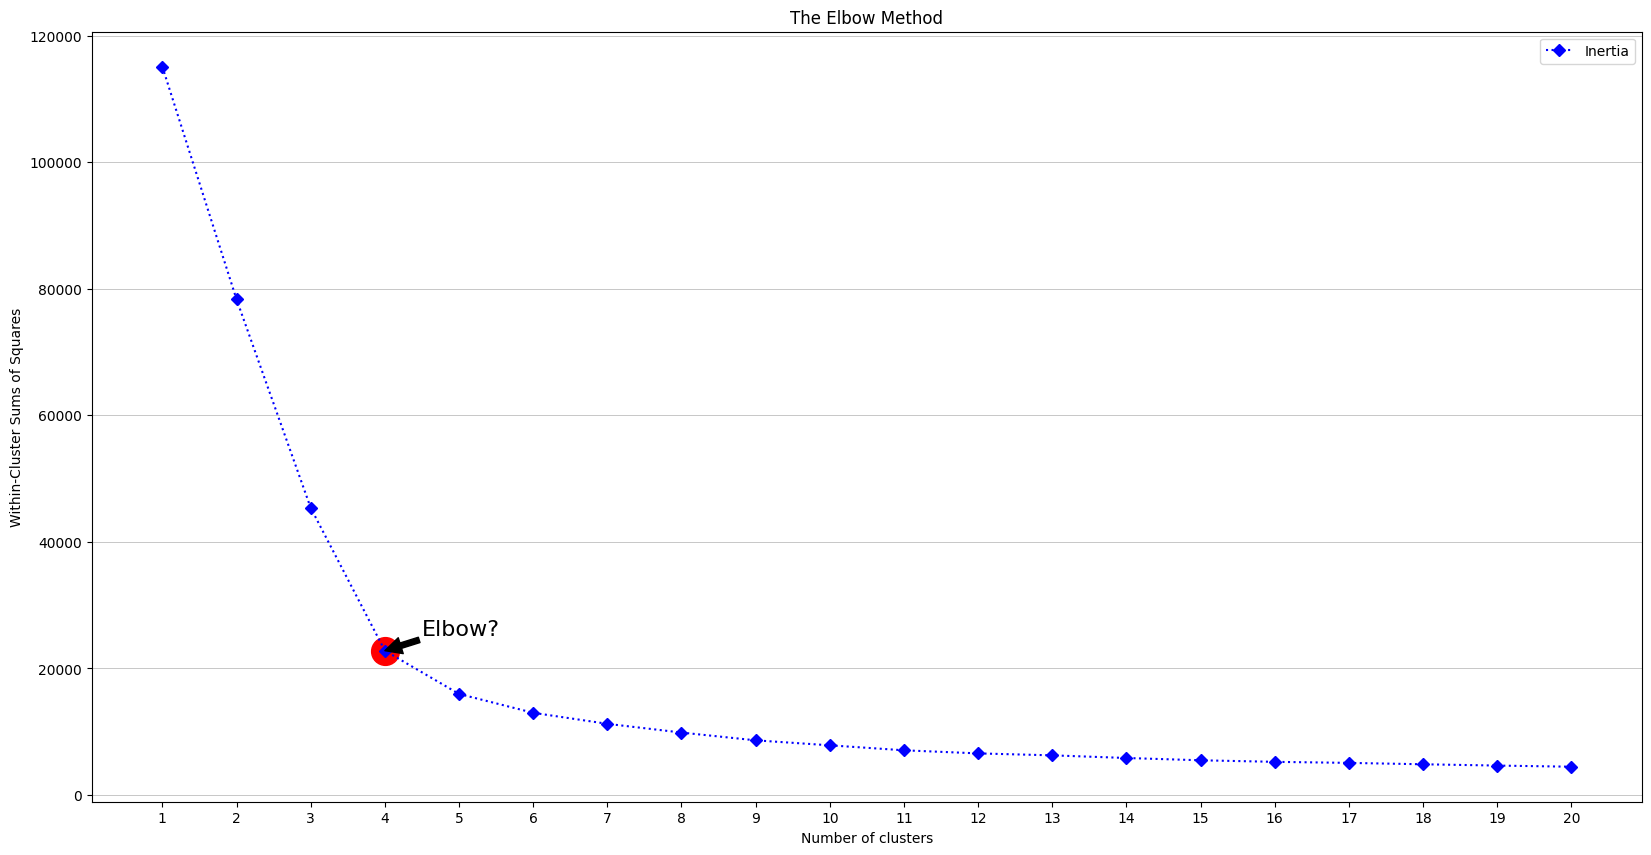

In [74]:
elbow_highlight = 4
with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(20,10))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(nb_clusters_to_try, wcss,color="blue",linestyle=":",marker="D",label="Inertia")
    # customizing
    ax.legend(loc="upper right")
    ax.set_title('The Elbow Method')
    ax.set_xticks(nb_clusters_to_try)
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('Within-Cluster Sums of Squares')
    ax.scatter(elbow_highlight,wcss[elbow_highlight-1],c='red',s=400)    
    # annotate
    ax.annotate("Elbow?", 
                (elbow_highlight,wcss[elbow_highlight-1]),
                (elbow_highlight+0.50,wcss[elbow_highlight-1]+5000), 
                arrowprops=dict(facecolor='black'),
                fontsize=16,
#                horizontalalignment='middle', 
                verticalalignment='top')
    
    ax.grid(axis="y",linewidth=0.5)
    plt.show()

In [84]:
kmeans_scaled = KMeans(n_clusters = 5)
kmeans_scaled.fit(test_proj)

KMeans(n_clusters=5)

In [85]:
labels_scaled = kmeans_scaled.labels_
labels_scaled

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [86]:
np.unique(labels_scaled, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int32),
 array([34101,   359,     1,   489,  3419]))

In [87]:
test_clusters = 5

print('Working with ' + str(test_clusters) + ' clusters as in DataSet', flush=True)
print("-"*80)

kmeans = KMeans(n_clusters = test_clusters, max_iter = 300)

kmeans.fit(test_proj)

labelling = kmeans.labels_

Working with 5 clusters as in DataSet
--------------------------------------------------------------------------------


In [88]:
test_labelled = pd.concat([test_df,pd.Series(labelling)],axis=1).rename(columns={0:"label"})
test_labelled = test_labelled.set_index('user_pseudo_id')
test_labelled

,device_category_desktop,device_category_mobile,device_category_tablet,device_category_nan,device_operating_system_<Other>,device_operating_system_Android,device_operating_system_Macintosh,device_operating_system_Web,device_operating_system_Windows,device_operating_system_iOS,device_operating_system_nan,device_web_info_browser_Chrome,device_web_info_browser_Safari,device_web_info_browser_web_info_browser_other,device_web_info_browser_nan,geo_country_Canada,geo_country_India,geo_country_Spain,geo_country_United Kingdom,geo_country_United States,geo_country_geo_country_other,geo_country_nan,traffic_source_medium_(data deleted),traffic_source_medium_(none),traffic_source_medium_<Other>,traffic_source_medium_cpc,traffic_source_medium_organic,traffic_source_medium_referral,traffic_source_medium_nan,visits_per_user_pseudo_id,pageviews_per_user_pseudo_id,events_per_visitor,engagement_time_per_visitor,clicks_per_visitor,user_engagements_per_visitor,scrolls_per_visitor,add_payment_info & Payment Method,add_shipping_info & Checkout Your Information,add_shipping_info & Other,add_to_cart & Product Listing Page,begin_checkout & Checkout Your Information,begin_checkout & Other,click & Checkout Review,click & Checkout Your Information,click & Home,click & Information,click & New Product Listing Page,click & Other,click & Payment Method,click & Product Display Page,click & Product Listing Page,click & Return Policy,click & Shipping Information,click & Shopping Cart,first_visit & Checkout Your Information,first_visit & Gift Cards,first_visit & Home,first_visit & Information,first_visit & New Product Listing Page,first_visit & Other,first_visit & Product Display Page,first_visit & Product Listing Page,first_visit & Return Policy,first_visit & Sale Product Listing Page,first_visit & Search Results,first_visit & Shipping Information,first_visit & Shopping Cart,page_view & Checkout Confirmation,page_view & Checkout Review,page_view & Checkout Your Information,page_view & Gift Cards,page_view & Home,page_view & Information,page_view & New Product Listing Page,page_view & Other,page_view & Payment Method,page_view & Product Display Page,page_view & Product Listing Page,page_view & Return Policy,page_view & Sale Product Listing Page,page_view & Search Results,page_view & Shipping Information,page_view & Shopping Cart,purchase & Product Listing Page,scroll & Checkout Confirmation,scroll & Checkout Review,scroll & Checkout Your Information,scroll & Gift Cards,scroll & Home,scroll & Information,scroll & New Product Listing Page,scroll & Other,scroll & Payment Method,scroll & Product Display Page,scroll & Product Listing Page,scroll & Return Policy,scroll & Sale Product Listing Page,scroll & Search Results,scroll & Shipping Information,scroll & Shopping Cart,select_promotion & Home,select_promotion & Product Listing Page,session_start & Checkout Confirmation,session_start & Checkout Review,session_start & Checkout Your Information,session_start & Gift Cards,session_start & Home,session_start & Information,session_start & New Product Listing Page,session_start & Other,session_start & Payment Method,session_start & Product Display Page,session_start & Product Listing Page,session_start & Return Policy,session_start & Sale Product Listing Page,session_start & Search Results,session_start & Shipping Information,session_start & Shopping Cart,user_engagement & Checkout Confirmation,user_engagement & Checkout Review,user_engagement & Checkout Your Information,user_engagement & Gift Cards,user_engagement & Home,user_engagement & Information,user_engagement & New Product Listing Page,user_engagement & Other,user_engagement & Payment Method,user_engagement & Product Display Page,user_engagement & Product Listing Page,user_engagement & Return Policy,user_engagement & Sale Product Listing Page,user_engagement & Search Results,user_engagement & Shipping Information,user_engagement & Shopping Cart,view_item & Gift Cards,view_item & Home,view_item & New Product Listing

In [89]:
customer_mixes = {}

for cluster in np.unique(labelling):
    customer_mixes[cluster] = test_labelled[test_labelled.label == cluster]

In [90]:
for key,value in customer_mixes.items():
    print("-"*50)
    print(f"Here are some customers in cluster {key+1}")
    print("-"*50)
    display(value.describe())

--------------------------------------------------
Here are some customers in cluster 1
--------------------------------------------------


,device_category_desktop,device_category_mobile,device_category_tablet,device_category_nan,device_operating_system_<Other>,device_operating_system_Android,device_operating_system_Macintosh,device_operating_system_Web,device_operating_system_Windows,device_operating_system_iOS,device_operating_system_nan,device_web_info_browser_Chrome,device_web_info_browser_Safari,device_web_info_browser_web_info_browser_other,device_web_info_browser_nan,geo_country_Canada,geo_country_India,geo_country_Spain,geo_country_United Kingdom,geo_country_United States,geo_country_geo_country_other,geo_country_nan,traffic_source_medium_(data deleted),traffic_source_medium_(none),traffic_source_medium_<Other>,traffic_source_medium_cpc,traffic_source_medium_organic,traffic_source_medium_referral,traffic_source_medium_nan,visits_per_user_pseudo_id,pageviews_per_user_pseudo_id,events_per_visitor,engagement_time_per_visitor,clicks_per_visitor,user_engagements_per_visitor,scrolls_per_visitor,add_payment_info & Payment Method,add_shipping_info & Checkout Your Information,add_shipping_info & Other,add_to_cart & Product Listing Page,begin_checkout & Checkout Your Information,begin_checkout & Other,click & Checkout Review,click & Checkout Your Information,click & Home,click & Information,click & New Product Listing Page,click & Other,click & Payment Method,click & Product Display Page,click & Product Listing Page,click & Return Policy,click & Shipping Information,click & Shopping Cart,first_visit & Checkout Your Information,first_visit & Gift Cards,first_visit & Home,first_visit & Information,first_visit & New Product Listing Page,first_visit & Other,first_visit & Product Display Page,first_visit & Product Listing Page,first_visit & Return Policy,first_visit & Sale Product Listing Page,first_visit & Search Results,first_visit & Shipping Information,first_visit & Shopping Cart,page_view & Checkout Confirmation,page_view & Checkout Review,page_view & Checkout Your Information,page_view & Gift Cards,page_view & Home,page_view & Information,page_view & New Product Listing Page,page_view & Other,page_view & Payment Method,page_view & Product Display Page,page_view & Product Listing Page,page_view & Return Policy,page_view & Sale Product Listing Page,page_view & Search Results,page_view & Shipping Information,page_view & Shopping Cart,purchase & Product Listing Page,scroll & Checkout Confirmation,scroll & Checkout Review,scroll & Checkout Your Information,scroll & Gift Cards,scroll & Home,scroll & Information,scroll & New Product Listing Page,scroll & Other,scroll & Payment Method,scroll & Product Display Page,scroll & Product Listing Page,scroll & Return Policy,scroll & Sale Product Listing Page,scroll & Search Results,scroll & Shipping Information,scroll & Shopping Cart,select_promotion & Home,select_promotion & Product Listing Page,session_start & Checkout Confirmation,session_start & Checkout Review,session_start & Checkout Your Information,session_start & Gift Cards,session_start & Home,session_start & Information,session_start & New Product Listing Page,session_start & Other,session_start & Payment Method,session_start & Product Display Page,session_start & Product Listing Page,session_start & Return Policy,session_start & Sale Product Listing Page,session_start & Search Results,session_start & Shipping Information,session_start & Shopping Cart,user_engagement & Checkout Confirmation,user_engagement & Checkout Review,user_engagement & Checkout Your Information,user_engagement & Gift Cards,user_engagement & Home,user_engagement & Information,user_engagement & New Product Listing Page,user_engagement & Other,user_engagement & Payment Method,user_engagement & Product Display Page,user_engagement & Product Listing Page,user_engagement & Return Policy,user_engagement & Sale Product Listing Page,user_engagement & Search Results,user_engagement & Shipping Information,user_engagement & Shopping Cart,view_item & Gift Cards,view_item & Home,view_item & New Product Listing

--------------------------------------------------
Here are some customers in cluster 2
--------------------------------------------------


,device_category_desktop,device_category_mobile,device_category_tablet,device_category_nan,device_operating_system_<Other>,device_operating_system_Android,device_operating_system_Macintosh,device_operating_system_Web,device_operating_system_Windows,device_operating_system_iOS,device_operating_system_nan,device_web_info_browser_Chrome,device_web_info_browser_Safari,device_web_info_browser_web_info_browser_other,device_web_info_browser_nan,geo_country_Canada,geo_country_India,geo_country_Spain,geo_country_United Kingdom,geo_country_United States,geo_country_geo_country_other,geo_country_nan,traffic_source_medium_(data deleted),traffic_source_medium_(none),traffic_source_medium_<Other>,traffic_source_medium_cpc,traffic_source_medium_organic,traffic_source_medium_referral,traffic_source_medium_nan,visits_per_user_pseudo_id,pageviews_per_user_pseudo_id,events_per_visitor,engagement_time_per_visitor,clicks_per_visitor,user_engagements_per_visitor,scrolls_per_visitor,add_payment_info & Payment Method,add_shipping_info & Checkout Your Information,add_shipping_info & Other,add_to_cart & Product Listing Page,begin_checkout & Checkout Your Information,begin_checkout & Other,click & Checkout Review,click & Checkout Your Information,click & Home,click & Information,click & New Product Listing Page,click & Other,click & Payment Method,click & Product Display Page,click & Product Listing Page,click & Return Policy,click & Shipping Information,click & Shopping Cart,first_visit & Checkout Your Information,first_visit & Gift Cards,first_visit & Home,first_visit & Information,first_visit & New Product Listing Page,first_visit & Other,first_visit & Product Display Page,first_visit & Product Listing Page,first_visit & Return Policy,first_visit & Sale Product Listing Page,first_visit & Search Results,first_visit & Shipping Information,first_visit & Shopping Cart,page_view & Checkout Confirmation,page_view & Checkout Review,page_view & Checkout Your Information,page_view & Gift Cards,page_view & Home,page_view & Information,page_view & New Product Listing Page,page_view & Other,page_view & Payment Method,page_view & Product Display Page,page_view & Product Listing Page,page_view & Return Policy,page_view & Sale Product Listing Page,page_view & Search Results,page_view & Shipping Information,page_view & Shopping Cart,purchase & Product Listing Page,scroll & Checkout Confirmation,scroll & Checkout Review,scroll & Checkout Your Information,scroll & Gift Cards,scroll & Home,scroll & Information,scroll & New Product Listing Page,scroll & Other,scroll & Payment Method,scroll & Product Display Page,scroll & Product Listing Page,scroll & Return Policy,scroll & Sale Product Listing Page,scroll & Search Results,scroll & Shipping Information,scroll & Shopping Cart,select_promotion & Home,select_promotion & Product Listing Page,session_start & Checkout Confirmation,session_start & Checkout Review,session_start & Checkout Your Information,session_start & Gift Cards,session_start & Home,session_start & Information,session_start & New Product Listing Page,session_start & Other,session_start & Payment Method,session_start & Product Display Page,session_start & Product Listing Page,session_start & Return Policy,session_start & Sale Product Listing Page,session_start & Search Results,session_start & Shipping Information,session_start & Shopping Cart,user_engagement & Checkout Confirmation,user_engagement & Checkout Review,user_engagement & Checkout Your Information,user_engagement & Gift Cards,user_engagement & Home,user_engagement & Information,user_engagement & New Product Listing Page,user_engagement & Other,user_engagement & Payment Method,user_engagement & Product Display Page,user_engagement & Product Listing Page,user_engagement & Return Policy,user_engagement & Sale Product Listing Page,user_engagement & Search Results,user_engagement & Shipping Information,user_engagement & Shopping Cart,view_item & Gift Cards,view_item & Home,view_item & New Product Listing

--------------------------------------------------
Here are some customers in cluster 3
--------------------------------------------------


,device_category_desktop,device_category_mobile,device_category_tablet,device_category_nan,device_operating_system_<Other>,device_operating_system_Android,device_operating_system_Macintosh,device_operating_system_Web,device_operating_system_Windows,device_operating_system_iOS,device_operating_system_nan,device_web_info_browser_Chrome,device_web_info_browser_Safari,device_web_info_browser_web_info_browser_other,device_web_info_browser_nan,geo_country_Canada,geo_country_India,geo_country_Spain,geo_country_United Kingdom,geo_country_United States,geo_country_geo_country_other,geo_country_nan,traffic_source_medium_(data deleted),traffic_source_medium_(none),traffic_source_medium_<Other>,traffic_source_medium_cpc,traffic_source_medium_organic,traffic_source_medium_referral,traffic_source_medium_nan,visits_per_user_pseudo_id,pageviews_per_user_pseudo_id,events_per_visitor,engagement_time_per_visitor,clicks_per_visitor,user_engagements_per_visitor,scrolls_per_visitor,add_payment_info & Payment Method,add_shipping_info & Checkout Your Information,add_shipping_info & Other,add_to_cart & Product Listing Page,begin_checkout & Checkout Your Information,begin_checkout & Other,click & Checkout Review,click & Checkout Your Information,click & Home,click & Information,click & New Product Listing Page,click & Other,click & Payment Method,click & Product Display Page,click & Product Listing Page,click & Return Policy,click & Shipping Information,click & Shopping Cart,first_visit & Checkout Your Information,first_visit & Gift Cards,first_visit & Home,first_visit & Information,first_visit & New Product Listing Page,first_visit & Other,first_visit & Product Display Page,first_visit & Product Listing Page,first_visit & Return Policy,first_visit & Sale Product Listing Page,first_visit & Search Results,first_visit & Shipping Information,first_visit & Shopping Cart,page_view & Checkout Confirmation,page_view & Checkout Review,page_view & Checkout Your Information,page_view & Gift Cards,page_view & Home,page_view & Information,page_view & New Product Listing Page,page_view & Other,page_view & Payment Method,page_view & Product Display Page,page_view & Product Listing Page,page_view & Return Policy,page_view & Sale Product Listing Page,page_view & Search Results,page_view & Shipping Information,page_view & Shopping Cart,purchase & Product Listing Page,scroll & Checkout Confirmation,scroll & Checkout Review,scroll & Checkout Your Information,scroll & Gift Cards,scroll & Home,scroll & Information,scroll & New Product Listing Page,scroll & Other,scroll & Payment Method,scroll & Product Display Page,scroll & Product Listing Page,scroll & Return Policy,scroll & Sale Product Listing Page,scroll & Search Results,scroll & Shipping Information,scroll & Shopping Cart,select_promotion & Home,select_promotion & Product Listing Page,session_start & Checkout Confirmation,session_start & Checkout Review,session_start & Checkout Your Information,session_start & Gift Cards,session_start & Home,session_start & Information,session_start & New Product Listing Page,session_start & Other,session_start & Payment Method,session_start & Product Display Page,session_start & Product Listing Page,session_start & Return Policy,session_start & Sale Product Listing Page,session_start & Search Results,session_start & Shipping Information,session_start & Shopping Cart,user_engagement & Checkout Confirmation,user_engagement & Checkout Review,user_engagement & Checkout Your Information,user_engagement & Gift Cards,user_engagement & Home,user_engagement & Information,user_engagement & New Product Listing Page,user_engagement & Other,user_engagement & Payment Method,user_engagement & Product Display Page,user_engagement & Product Listing Page,user_engagement & Return Policy,user_engagement & Sale Product Listing Page,user_engagement & Search Results,user_engagement & Shipping Information,user_engagement & Shopping Cart,view_item & Gift Cards,view_item & Home,view_item & New Product Listing

--------------------------------------------------
Here are some customers in cluster 4
--------------------------------------------------


,device_category_desktop,device_category_mobile,device_category_tablet,device_category_nan,device_operating_system_<Other>,device_operating_system_Android,device_operating_system_Macintosh,device_operating_system_Web,device_operating_system_Windows,device_operating_system_iOS,device_operating_system_nan,device_web_info_browser_Chrome,device_web_info_browser_Safari,device_web_info_browser_web_info_browser_other,device_web_info_browser_nan,geo_country_Canada,geo_country_India,geo_country_Spain,geo_country_United Kingdom,geo_country_United States,geo_country_geo_country_other,geo_country_nan,traffic_source_medium_(data deleted),traffic_source_medium_(none),traffic_source_medium_<Other>,traffic_source_medium_cpc,traffic_source_medium_organic,traffic_source_medium_referral,traffic_source_medium_nan,visits_per_user_pseudo_id,pageviews_per_user_pseudo_id,events_per_visitor,engagement_time_per_visitor,clicks_per_visitor,user_engagements_per_visitor,scrolls_per_visitor,add_payment_info & Payment Method,add_shipping_info & Checkout Your Information,add_shipping_info & Other,add_to_cart & Product Listing Page,begin_checkout & Checkout Your Information,begin_checkout & Other,click & Checkout Review,click & Checkout Your Information,click & Home,click & Information,click & New Product Listing Page,click & Other,click & Payment Method,click & Product Display Page,click & Product Listing Page,click & Return Policy,click & Shipping Information,click & Shopping Cart,first_visit & Checkout Your Information,first_visit & Gift Cards,first_visit & Home,first_visit & Information,first_visit & New Product Listing Page,first_visit & Other,first_visit & Product Display Page,first_visit & Product Listing Page,first_visit & Return Policy,first_visit & Sale Product Listing Page,first_visit & Search Results,first_visit & Shipping Information,first_visit & Shopping Cart,page_view & Checkout Confirmation,page_view & Checkout Review,page_view & Checkout Your Information,page_view & Gift Cards,page_view & Home,page_view & Information,page_view & New Product Listing Page,page_view & Other,page_view & Payment Method,page_view & Product Display Page,page_view & Product Listing Page,page_view & Return Policy,page_view & Sale Product Listing Page,page_view & Search Results,page_view & Shipping Information,page_view & Shopping Cart,purchase & Product Listing Page,scroll & Checkout Confirmation,scroll & Checkout Review,scroll & Checkout Your Information,scroll & Gift Cards,scroll & Home,scroll & Information,scroll & New Product Listing Page,scroll & Other,scroll & Payment Method,scroll & Product Display Page,scroll & Product Listing Page,scroll & Return Policy,scroll & Sale Product Listing Page,scroll & Search Results,scroll & Shipping Information,scroll & Shopping Cart,select_promotion & Home,select_promotion & Product Listing Page,session_start & Checkout Confirmation,session_start & Checkout Review,session_start & Checkout Your Information,session_start & Gift Cards,session_start & Home,session_start & Information,session_start & New Product Listing Page,session_start & Other,session_start & Payment Method,session_start & Product Display Page,session_start & Product Listing Page,session_start & Return Policy,session_start & Sale Product Listing Page,session_start & Search Results,session_start & Shipping Information,session_start & Shopping Cart,user_engagement & Checkout Confirmation,user_engagement & Checkout Review,user_engagement & Checkout Your Information,user_engagement & Gift Cards,user_engagement & Home,user_engagement & Information,user_engagement & New Product Listing Page,user_engagement & Other,user_engagement & Payment Method,user_engagement & Product Display Page,user_engagement & Product Listing Page,user_engagement & Return Policy,user_engagement & Sale Product Listing Page,user_engagement & Search Results,user_engagement & Shipping Information,user_engagement & Shopping Cart,view_item & Gift Cards,view_item & Home,view_item & New Product Listing

--------------------------------------------------
Here are some customers in cluster 5
--------------------------------------------------


,device_category_desktop,device_category_mobile,device_category_tablet,device_category_nan,device_operating_system_<Other>,device_operating_system_Android,device_operating_system_Macintosh,device_operating_system_Web,device_operating_system_Windows,device_operating_system_iOS,device_operating_system_nan,device_web_info_browser_Chrome,device_web_info_browser_Safari,device_web_info_browser_web_info_browser_other,device_web_info_browser_nan,geo_country_Canada,geo_country_India,geo_country_Spain,geo_country_United Kingdom,geo_country_United States,geo_country_geo_country_other,geo_country_nan,traffic_source_medium_(data deleted),traffic_source_medium_(none),traffic_source_medium_<Other>,traffic_source_medium_cpc,traffic_source_medium_organic,traffic_source_medium_referral,traffic_source_medium_nan,visits_per_user_pseudo_id,pageviews_per_user_pseudo_id,events_per_visitor,engagement_time_per_visitor,clicks_per_visitor,user_engagements_per_visitor,scrolls_per_visitor,add_payment_info & Payment Method,add_shipping_info & Checkout Your Information,add_shipping_info & Other,add_to_cart & Product Listing Page,begin_checkout & Checkout Your Information,begin_checkout & Other,click & Checkout Review,click & Checkout Your Information,click & Home,click & Information,click & New Product Listing Page,click & Other,click & Payment Method,click & Product Display Page,click & Product Listing Page,click & Return Policy,click & Shipping Information,click & Shopping Cart,first_visit & Checkout Your Information,first_visit & Gift Cards,first_visit & Home,first_visit & Information,first_visit & New Product Listing Page,first_visit & Other,first_visit & Product Display Page,first_visit & Product Listing Page,first_visit & Return Policy,first_visit & Sale Product Listing Page,first_visit & Search Results,first_visit & Shipping Information,first_visit & Shopping Cart,page_view & Checkout Confirmation,page_view & Checkout Review,page_view & Checkout Your Information,page_view & Gift Cards,page_view & Home,page_view & Information,page_view & New Product Listing Page,page_view & Other,page_view & Payment Method,page_view & Product Display Page,page_view & Product Listing Page,page_view & Return Policy,page_view & Sale Product Listing Page,page_view & Search Results,page_view & Shipping Information,page_view & Shopping Cart,purchase & Product Listing Page,scroll & Checkout Confirmation,scroll & Checkout Review,scroll & Checkout Your Information,scroll & Gift Cards,scroll & Home,scroll & Information,scroll & New Product Listing Page,scroll & Other,scroll & Payment Method,scroll & Product Display Page,scroll & Product Listing Page,scroll & Return Policy,scroll & Sale Product Listing Page,scroll & Search Results,scroll & Shipping Information,scroll & Shopping Cart,select_promotion & Home,select_promotion & Product Listing Page,session_start & Checkout Confirmation,session_start & Checkout Review,session_start & Checkout Your Information,session_start & Gift Cards,session_start & Home,session_start & Information,session_start & New Product Listing Page,session_start & Other,session_start & Payment Method,session_start & Product Display Page,session_start & Product Listing Page,session_start & Return Policy,session_start & Sale Product Listing Page,session_start & Search Results,session_start & Shipping Information,session_start & Shopping Cart,user_engagement & Checkout Confirmation,user_engagement & Checkout Review,user_engagement & Checkout Your Information,user_engagement & Gift Cards,user_engagement & Home,user_engagement & Information,user_engagement & New Product Listing Page,user_engagement & Other,user_engagement & Payment Method,user_engagement & Product Display Page,user_engagement & Product Listing Page,user_engagement & Return Policy,user_engagement & Sale Product Listing Page,user_engagement & Search Results,user_engagement & Shipping Information,user_engagement & Shopping Cart,view_item & Gift Cards,view_item & Home,view_item & New Product Listing

In [92]:
test_df['previous_purchase'].max()

0.0

In [12]:
for num in range(5):
    var = num

In [13]:
var

4